## Optimal Distance Assignment Strategy - Smart Route Optimization Algorithm

### Algorithm Type: **Dynamic Route Optimization with Total Distance Minimization**

The Optimal Distance Assignment Strategy implements a **Smart Route Optimization Algorithm** that considers not only the distance to the new task's pickup location, but also the total additional travel distance when the new task is integrated into each drone's existing task queue.

### How it works:
1. **Queue Analysis**: For each drone, analyze its current task queue and planned route
2. **Route Integration**: Calculate the optimal insertion point for the new task in each drone's route
3. **Distance Calculation**: Compute the total additional distance required when inserting the new task
4. **Optimal Selection**: Choose the drone that results in the minimum total additional travel distance
5. **Dynamic Insertion**: Insert the task at the optimal position in the selected drone's queue

### Key Characteristics:

**Intelligence**: 
- Considers existing workload and routing context
- Optimizes for total system efficiency rather than just proximity
- Dynamically adapts to current operational state

**Efficiency**: 
- Minimizes total fleet travel distance
- Reduces overall fuel consumption and delivery time
- Optimizes resource utilization across the entire system

**Adaptability**: 
- Adjusts decisions based on real-time drone states
- Considers current task queues and planned routes
- Responds to varying operational conditions

### Algorithm Steps:
1. Receive a new delivery task T
2. For each operational drone D:
   - Get current task queue: [T₁, T₂, ..., Tₙ]
   - Calculate current planned route distance: `route_distance(current_queue)`
   - For each possible insertion position i (0 to n+1):
     - Create new queue: [T₁, ..., Tᵢ, T, Tᵢ₊₁, ..., Tₙ]
     - Calculate new route distance: `route_distance(new_queue)`
     - Compute additional distance: `additional_distance = new_route - current_route`
   - Record minimum additional distance for drone D
3. Select drone with minimum additional distance: `D* = argmin(additional_distance(D, T))`
4. Insert task T at the optimal position in D*'s queue

### Use Cases:
- **Fleet optimization** where total operational cost is critical
- **High-density delivery services** with multiple concurrent tasks per drone
- **Resource-constrained environments** where efficiency is paramount
- **Complex urban delivery networks** with varying distances and traffic patterns
- **Long-term operational optimization** focusing on system-wide performance

### Mathematical Foundation:
```
For task T and drone D with current queue Q = [T₁, T₂, ..., Tₙ]:

Current route distance:
R(Q) = distance(drone_pos, T₁) + Σ(distance(Tᵢ.destination, Tᵢ₊₁.origin)) + distance(Tₙ.destination, drone_pos)

For insertion at position i:
Q' = [T₁, ..., Tᵢ, T, Tᵢ₊₁, ..., Tₙ]
Additional distance = R(Q') - R(Q)

Optimal assignment:
D* = argmin(min_insertion_position(additional_distance(D, T))) for all drones D
```

### Trade-offs:
**Advantages:**
- Globally optimized route planning
- Minimizes total system operational costs
- Considers real-time operational context
- Better long-term efficiency than greedy approaches
- Intelligent task queue management

**Disadvantages:**
- Higher computational complexity O(n×m×k) where n=drones, m=avg_queue_size, k=insertion_positions
- More complex implementation and debugging
- May have longer initial response times due to optimization calculations
- Requires maintaining detailed state information for all drones

### Comparison with Other Strategies:

**vs Fair Assignment:**
- More efficient but potentially less balanced workload
- Considers route optimization vs simple round-robin

**vs Nearest Assignment:**
- More intelligent but computationally more expensive
- Considers entire route context vs just pickup proximity

**vs All Strategies:**
- Highest optimization potential for total system efficiency
- Best suited for scenarios where operational cost minimization is the primary goal

This algorithm is ideal when **minimizing total operational costs** and **maximizing system-wide efficiency** are more important than simplicity or guaranteed workload balance. It's particularly effective in scenarios with high task density and complex routing requirements.

In [1]:
# DRONE_COUNT = 1
from Common import DroneAssignmentsProblemSimulator, SimPlot
from Config import (
    BATCH_SIZE,
    CLUSTER_DATA_FILE,
    DATA_CSV_FILE,
    DRONE_COUNT,
    DT,
    EXPECT_CSV_FILE,
    N_CLUSTERS,
    WAITING_TIME,
    J,
)
from dronesim.mission import DeliveryTask
from dronesim.unit import Minute, Time

In [2]:


class OptimalDistanceAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """Nearest Drone Assignment Strategy implementing Greedy Distance-Based Algorithm.
    Assigns each task to the closest available drone based on geographical proximity.
    """

    def __init__(self, drone_count: int = 50, wating_time: Time = Minute(1)):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.current = wating_time
        self.wating_time = wating_time

    def sim_update(self, dt, now):
        """Update the simulation state by assigning tasks to nearest available drones."""
        if now < self.current:
            return
        self.current += self.wating_time

        for task in self.get_pending_tasks():
            # Find the nearest available drone to the task's origin
            if not self._find_optimal_drone(task, now):
                self.failed_to_assign_task(task)
                break

    def _find_optimal_drone(self, task: DeliveryTask, now):
        """Find the drone with minimum distance to the task's origin."""
        # Only consider operational drones (not full and has battery)
        available_drones = [drone for drone in self.get_vehicles() if drone.is_operational()]
        if len(available_drones) == 0:
            return False

        drone_distances = []

        for drone in available_drones:
            d, e = drone.estimate_mission_budget(task)
            drone_distances.append((drone, d, e))

        # Sort by distance (ascending) - using float conversion for sorting
        drone_distances.sort(key=lambda x: float(x[1]))

        # Try to assign to drones in order of proximity
        for drone, d, e in drone_distances:
            if drone.assign(task):
                # print(f"드론 {drone.id} 에게 할당 성공 (거리: {d} m, 필요 에너지: {e} Wh, 남은 배터리: {drone.battery.current} Wh) 할당된 태스크 수: {len(drone.current_tasks)} 상태: {drone.current_state}")
                return True
            # print(f"드론 {drone.id} 에게 할당 실패 (거리: {d} m, 필요 에너지: {e} Wh, 남은 배터리: {drone.battery.current} Wh) 할당된 태스크 수: {len(drone.current_tasks)} 상태: {drone.current_state}")

        return False

    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

In [3]:
# Run Optimal Distance Assignment Strategy simulation
optimal_sim = OptimalDistanceAssignmentStrategy(DRONE_COUNT, wating_time=WAITING_TIME)
optimal_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT, batch_size=BATCH_SIZE)
p_optimal = SimPlot(optimal_sim, EXPECT_CSV_FILE)


Output()

Clustering 2878 points into 10 clusters

Successfully created 10 cluster bases:

(12.9793 °N/S, 77.6414 °E/W) - Store Count: 575

(12.9499 °N/S, 77.6994 °E/W) - Store Count: 150

(12.9341 °N/S, 77.6152 °E/W) - Store Count: 730

(13.0292 °N/S, 77.571 °E/W) - Store Count: 155

(12.9724 °N/S, 77.6023 °E/W) - Store Count: 277

(12.9137 °N/S, 77.6808 °E/W) - Store Count: 280

(12.9062 °N/S, 77.5968 °E/W) - Store Count: 133

(12.9754 °N/S, 77.6967 °E/W) - Store Count: 143

(12.9703 °N/S, 77.6456 °E/W) - Store Count: 297

(12.9395 °N/S, 77.626 °E/W) - Store Count: 138

╭──────────────────────────────────────────────── Current States ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task - ASSIGNED:                   0                                                                           │
│  Task - GO_PICKUP:                  0                                                                           │
│  Task - SERVICE_PICKUP:             0                                                                           │
│  Task - GO_DROPOFF:                 0                                                                           │
│  Task - SERVICE_DROPOFF:            0                                                                           │
│  Task - DONE:                       2878                                                                        │
│  Task - ABORTED:                    0                                                                           │
│  Vehicle - GROUNDED:                161                                                                         │
│  Vehicle - TAKING_OFF:              3                                                                           │
│  Vehicle - NAVIGATING:              35                                                                          │
│  Vehicle - LANDING:                 1                                                                           │
│  Vehicle - EMERGENCY:               0                                                                           │
│  Average Task Time:                 00:23:16.531                                                                │
│  Task Time Standard Deviation:      00:06:26.478                                                                │
│  Max Vehicle Utilization:           95.5%                                                                       │
│  Operational Vehicles Percentage:   80.5%                                                                       │
│  Pending Queue Size:                0                                                                           │
│  Cooldown Queue Size:               0                                                                           │
│  Working Queue Size:                0                                                                           │
│  Completed Queue Size:              2878                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
Total simulation tasks: 2878
=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Task Processing Speed Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
Total simulation tasks: 2878
=== Task Processing Speed Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Vehicle Battery Consumption Analysis ===
Input data points: 2248
Valid data points for analysis: 2248


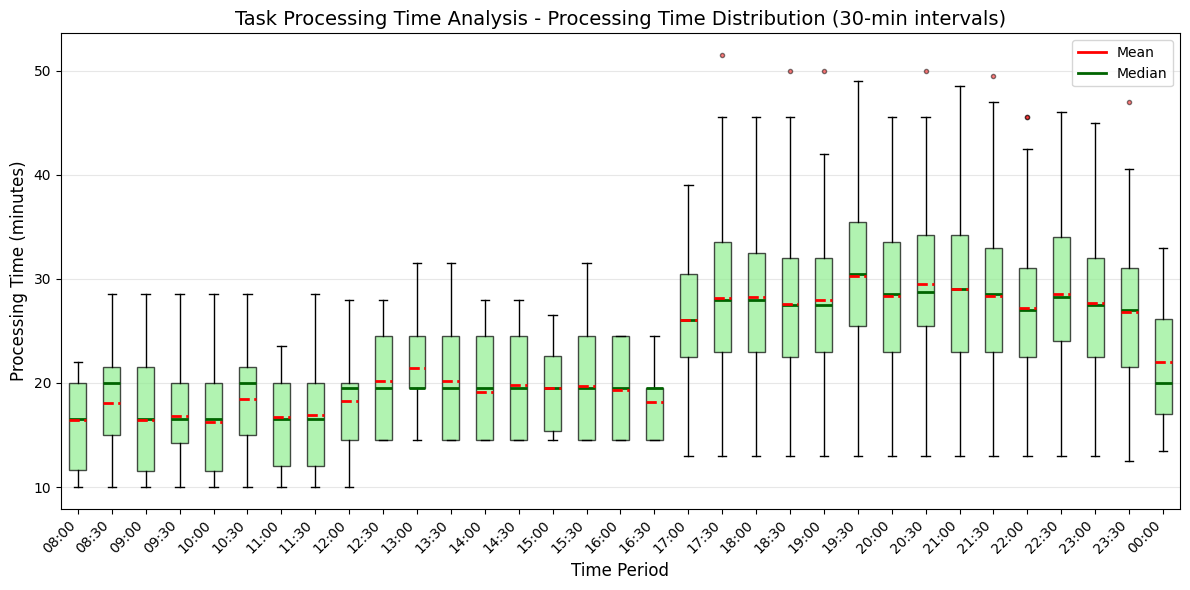

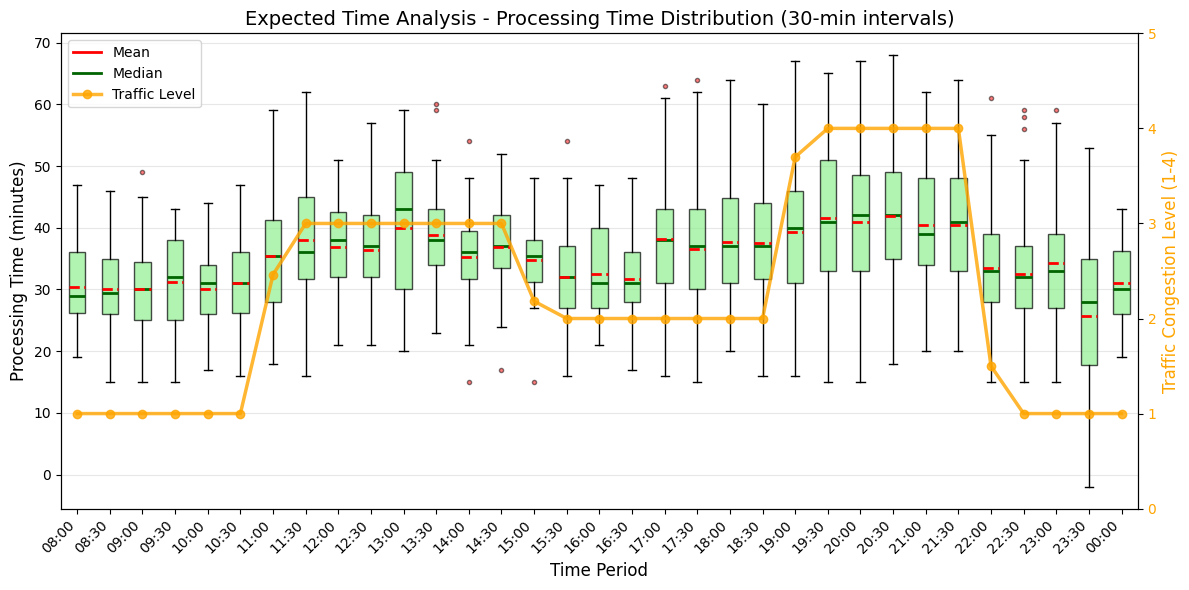

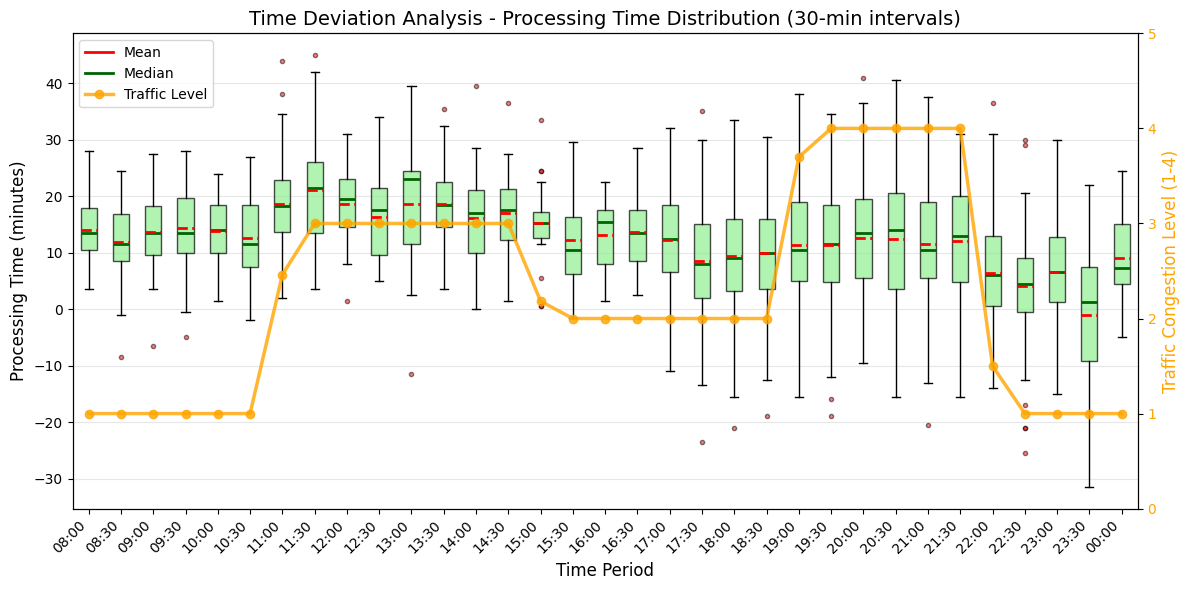

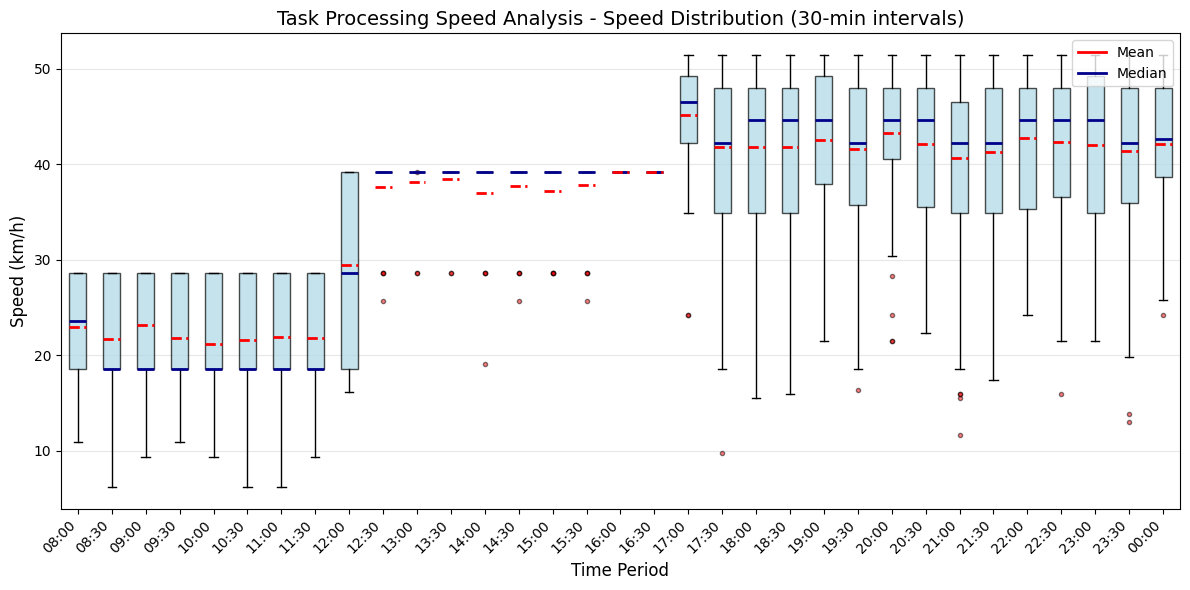

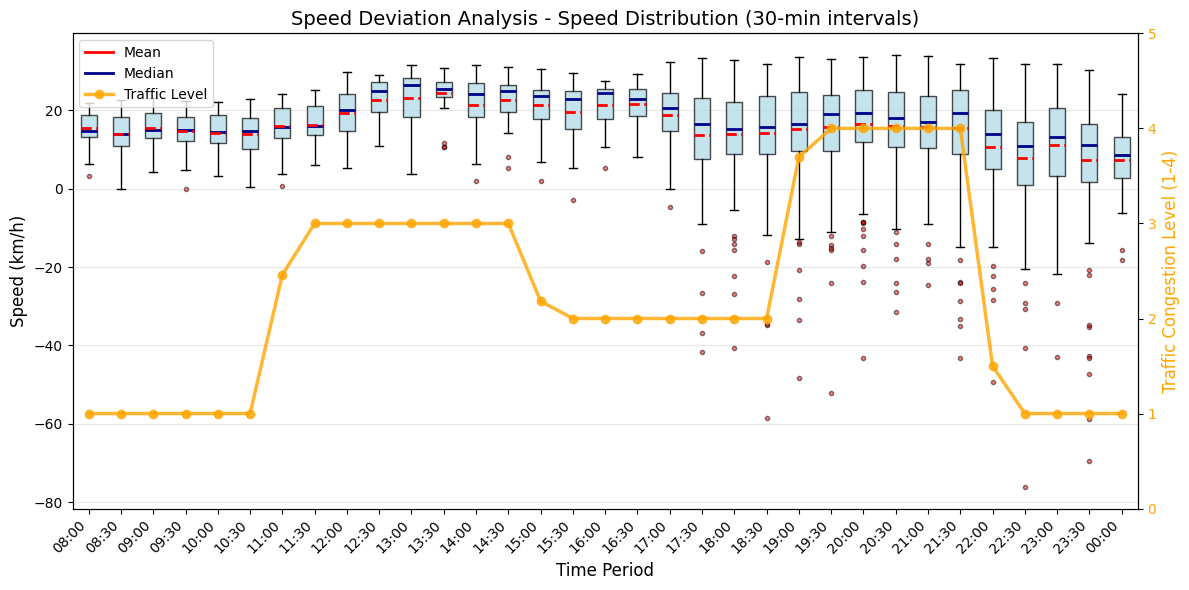

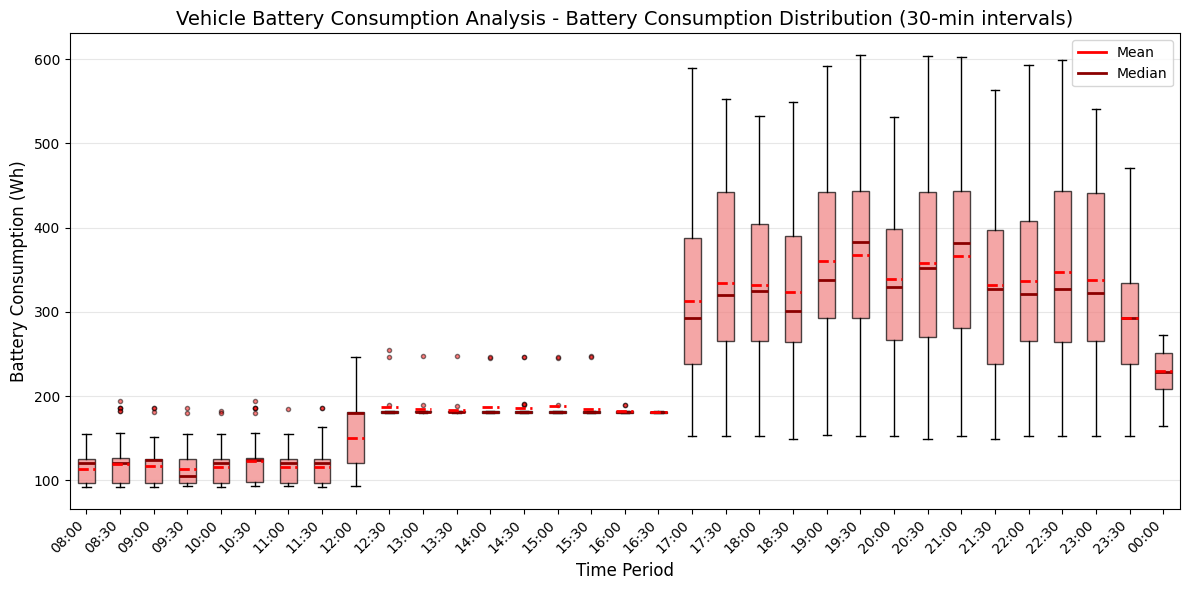

In [4]:
p_optimal = SimPlot(optimal_sim, EXPECT_CSV_FILE)
p_optimal.task_processing_times()
p_optimal.expected_time_analysis()
p_optimal.deviation_in_time_taken()
p_optimal.task_speed()
p_optimal.deviation_speed()
p_optimal.battery_usage()
p_optimal.show()